<a href="https://colab.research.google.com/github/ichiyan/BrainDecoding/blob/master/frmi_vae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
!pip install bdpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Imports

In [4]:
import bdpy
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
import h5py
from sklearn.preprocessing import StandardScaler


root_path = 'gdrive/My Drive/coding_projects/brain_decoding/'
data_path = root_path + 'data/DIR/fMRI/train/'

# Accessing fMRI data

## DIR dataset
- refer to this for usage of bdpy: https://github.com/KamitaniLab/bdpy/blob/main/docs/bdata_api_examples.md 

In [ ]:
dat = bdpy.BData(data_path + 'sub-01_perceptionNaturalImageTraining_original_VC.h5')
# contains peak BOLD signals of voxels, not BOLD signals of voxels over time (as in time-series data)
vc = dat.select('ROI_VC = 1')

# stimulus image index (refer to excel sheet for corresponding image filename)
# img_ndx = dat.select('image_index')

# vc[0] ==> voxel values in the visual cortex (first sample)
print(vc.shape)
print(vc[0].shape)
print(dat.show_metadata())

(6000, 11726)
(11726,)
| Key         | Description          |
|-------------|----------------------|
| VoxelData   | 1 = VoxelData        |
| Run         | 1 = Run              |
| Block       | 1 = Block            |
| Label       | 1 = Label            |
| image_index | Label stimulus_index |
| stimulus_id | Label stimulus_id    |
| voxel_x     | Voxel x coordinate   |
| voxel_y     | Voxel y coordinate   |
| voxel_z     | Voxel z coordinate   |
| ROI_V1      | 1 = ROI V1           |
| ROI_V2      | 1 = ROI V2           |
| ROI_V3      | 1 = ROI V3           |
| ROI_V4      | 1 = ROI V4           |
| ROI_LOC     | 1 = ROI LOC          |
| ROI_FFA     | 1 = ROI FFA          |
| ROI_PPA     | 1 = ROI PPA          |
| ROI_LVC     | 1 = ROI LVC          |
| ROI_HVC     | 1 = ROI HVC          |
| ROI_VC      | 1 = ROI VC           |
None


In [ ]:
df = pd.DataFrame(vc[0])
df.describe()

,0
count,11726.000000
mean,1.665917
std,9.247541
min,-71.087392
25%,-2.847371
50%,1.695641
75%,6.252123
max,71.077556


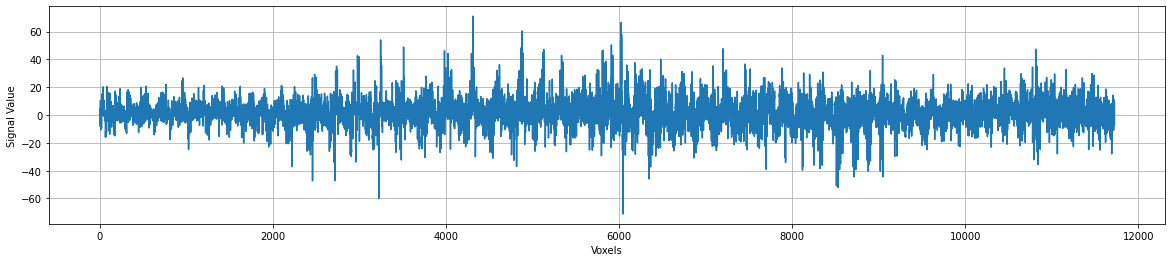

In [ ]:
x_axis = np.arange(0, vc[0].shape[0])
plt.figure(figsize=(20, 4))
plt.plot(x_axis, vc[0])

plt.xlabel('Voxels')
plt.ylabel('Signal Value')

plt.grid()


## NSD dataset

TODO: 
- [x] test autoencoderKL with some COCO images (NSD img stimuli)
    - only tested < 10 for now cause time and lacked RAM
- [ ] plot many class representative images 
  - if results aren't great enough: proceed with DIR for the meantime or consider using microsoft's pre-trained VQ-VAE if possible   
- [x] access fMRI data 
- [ ] confirm data acquisition and preprossesing in NSD paper

# Load Data

In [5]:
dataset = 'NSD'
if dataset == 'NSD':
  !wget -c https://huggingface.co/datasets/pscotti/naturalscenesdataset/resolve/main/COCO_73k_subj_indices.hdf5

--2022-12-09 17:40:55--  https://huggingface.co/datasets/pscotti/naturalscenesdataset/resolve/main/COCO_73k_subj_indices.hdf5
Resolving huggingface.co (huggingface.co)... 3.234.187.147, 54.147.99.175, 2600:1f18:147f:e850:d78f:7d9d:6ec3:2aee, ...
Connecting to huggingface.co (huggingface.co)|3.234.187.147|:443... connected.
HTTP request sent, awaiting response... 416 Range Not Satisfiable

    The file is already fully retrieved; nothing to do.



In [11]:
if dataset == 'DIR':
  pass
  # train = bdpy.BData(root_path + 'data/DIR/fMRI/train/sub-01_perceptionNaturalImageTraining_original_VC.h5')
  # test = bdpy.BData(root_path + 'data/DIR/fMRI/test/sub-01_perceptionNaturalImageTraining_original_VC.h5')
  # train_voxels = train.select('ROI_VC = 1')
  # test_voxels = train.select('ROI_VC = 1')
  
elif dataset == 'NSD':
  subject = 'subj01'
  data_path = root_path + 'data/NSD/'
  f = h5py.File(f'{data_path}{subject}_nsdgeneral.hdf5', 'r')
  voxels = f['voxels']
  n_voxels = len(voxels)

  # 80-10-10 split
  # n_train = int(n_voxels*0.8)
  # n_val = int(n_voxels*0.1)
  # n_test = int(n_voxels*0.1)

  # scanning sessions (37 total) were done in increments of 750 trials
  # each scanning session is independent from each other
  # dividing the dataset in multiples of 750 would ensure that there is no data contamination
  n_train = 750*29     # 21,750 / 78%
  n_val = 750*6        #  4,500 / 16%
  n_test = 750*2       #  1,500 /  5%
  
  train_voxels = voxels[:n_train]
  val_voxels = voxels[n_train:n_train + n_val]
  test_voxels = voxels[n_train + n_val: n_train + n_val + n_test]

  # ensuring that no validation trials w/ images presented in training data
  # is this necessary for fMRI VAE or only for LDM?
  # since fMRI VAE only deals with voxel data that are defferent even between those w/ same stimulus

  # f = h5py.File('COCO_73k_subj_indices.hdf5', 'r')
  # all_73KID = f[subject]
  # train_ind = all_73KID[:n_train]
  # val_ind = all_73KID[n_train:n_train + n_val_test]

  # exclude_repeats = ~np.isin(val_ind, train_ind)
  # val_voxels = val_voxels[exclude_repeats]

  # del all_73KID
  # f.close()

  print(train_voxels.shape, val_voxels.shape, test_voxels.shape)
  
  

(21750, 15724) (4500, 15724) (1500, 15724)


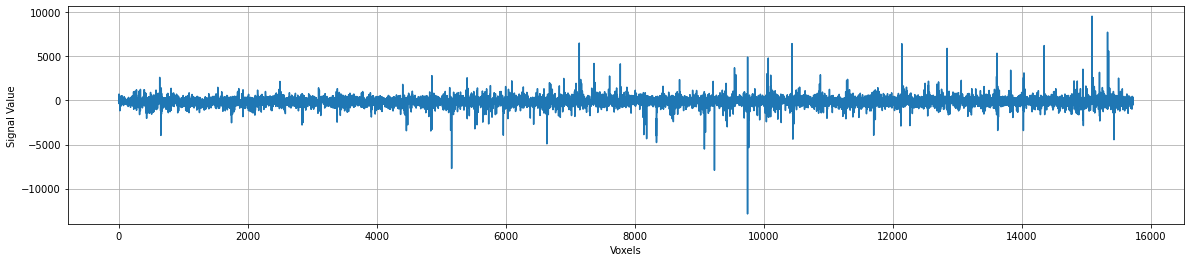

In [12]:
def plot_voxels(voxels):
  x_axis = np.arange(0, voxels[1].shape[0])
  plt.figure(figsize=(20, 4))
  plt.plot(x_axis, voxels[0])

  plt.xlabel('Voxels')
  plt.ylabel('Signal Value')

  plt.grid()

plot_voxels(train_voxels)

Standardization
- refer to: https://lukas-snoek.com/NI-edu/fMRI-pattern-analysis/week_2/decoding_analyses.html#standardization 
- concern: the linked material mentions to standardize runs independently however idk if run data can be accessed in the current NSD dataset, but I think this can be done w/ the DIR dataset. For now, data is standardized all at once which I think is what is done in the GOD feature prediction: https://github.com/KamitaniLab/GenericObjectDecoding/blob/master/code/python/analysis_FeaturePrediction.py 
- consider testing: w/o standardization/normalization

(15724,)
(15724,)


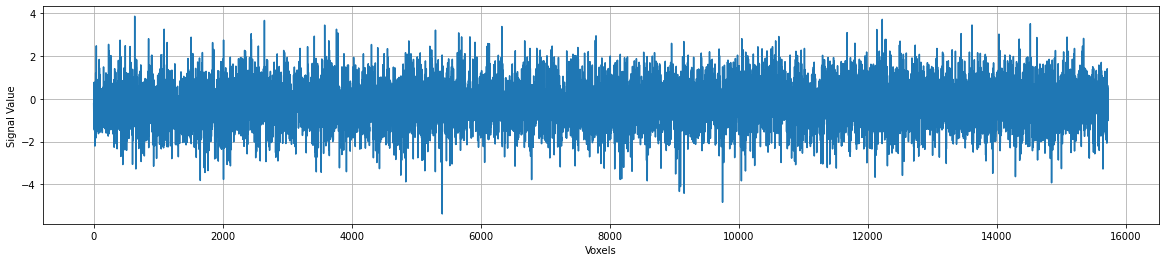

In [14]:
scaler = StandardScaler()
train_norm = scaler.fit_transform(train_voxels)
plot_voxels(train_norm)
print(scaler.mean_.shape)
print(scaler.scale_.shape)

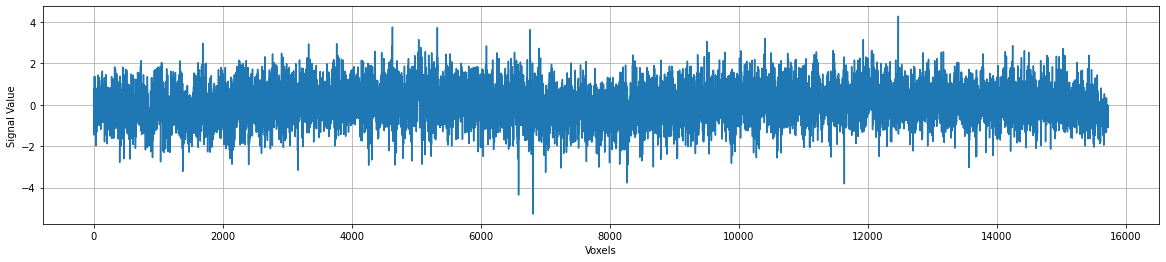

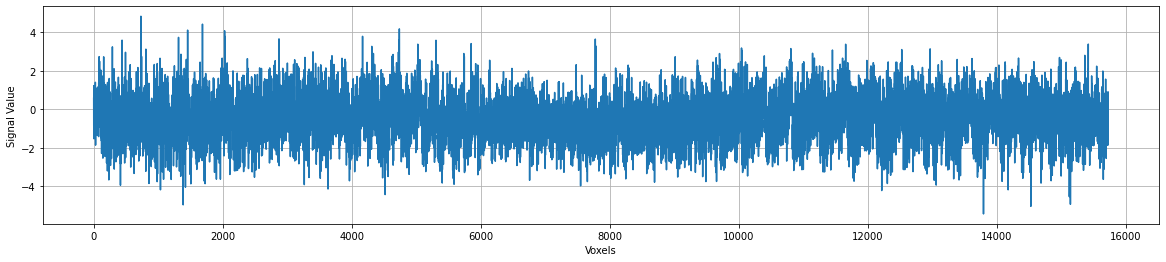

In [15]:
val_norm = scaler.transform(val_voxels)
test_norm = scaler.transform(test_voxels)
plot_voxels(val_norm)
plot_voxels(test_norm)